In [1]:
import os
import sys

In [2]:
import glob
import math
import time
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
import sklearn.metrics
from sklearn.model_selection import StratifiedKFold
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import RandomSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
import albumentations
from efficientnet_pytorch import model as enet\

device = torch.device('cuda')

In [3]:
kernel_type = 'effnet-b1-unseen'
enet_type = 'efficientnet-b1'
fold = 0
HEIGHT = 137
WIDTH = 236
image_size = 128
cut_size = int(image_size * 0.85)
data_dir = 'bengali/'
batch_size = 128
num_workers = 4
init_lr = 0.001
c0_dim = 1295
c1_dim = 168
c2_dim = 11
c3_dim = 7
out_dim = c0_dim + c1_dim + c2_dim + c3_dim
loss_weight = [4, 2, 1, 1]
n_epochs = 30
use_amp = False

files_train = [f'bengaliai-cv19-feather/train_image_data_{fid}.feather' for fid in range(4)]
files_test = [f'bengaliai-cv19-feather/test_image_data_{fid}.feather' for fid in range(4)]

df_train = pd.read_csv(os.path.join(data_dir, f'train.csv'))
df_class_map = pd.read_csv(os.path.join(data_dir, f'class_map.csv'))

id2grapheme = {i: grapheme for i, grapheme in enumerate(df_train.grapheme.unique())}
grapheme2id = {grapheme: i for i, grapheme in enumerate(df_train.grapheme.unique())}
df_train['grapheme_id'] = df_train['grapheme'].map(grapheme2id)

n_fold = 5
skf = StratifiedKFold(n_fold, random_state=42)
for i_fold, (train_idx, val_idx) in enumerate(skf.split(df_train, df_train.grapheme)):
    df_train.loc[val_idx, 'fold'] = i_fold
df_train['fold'] = df_train['fold'].astype(int)

df_label_map = []
for i, df in tqdm(df_train.groupby('grapheme_id')):
    df_label_map.append(df.iloc[:, 1:6].drop_duplicates())
df_label_map = pd.concat(df_label_map).reset_index(drop=True)

/home/pengfei/miniconda3/envs/xray/lib/python3.8/site-packages/sklearn/model_selection/_split.py:292: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
<ipython-input-3-86b57446a1eb>:38: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, df in tqdm(df_train.groupby('grapheme_id')):


# Data & Dataset

In [4]:
def read_data(files):
    tmp = []
    for f in files:
        F = os.path.join(data_dir, f)
        data = pd.read_feather(F)
        res = data.iloc[:, 1:].values
        imgs = []
        for i in tqdm(range(res.shape[0])):
            img = res[i].squeeze().reshape(HEIGHT, WIDTH)
            img = cv2.resize(img, (128, 128))
            imgs.append(img)
        imgs = np.asarray(imgs)
        
        tmp.append(imgs)
    tmp = np.concatenate(tmp, 0)
    return tmp


class BengaliDataset(Dataset):
    def __init__(self, csv, data, idx, split, mode, transform=None):

        self.csv = csv.reset_index()
        self.data = data
        self.idx = np.asarray(idx)
        self.split = split
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.idx.shape[0]

    def __getitem__(self, index):
        index = self.idx[index]
        this_img_id = self.csv.iloc[index].image_id
        
        image = self.data[index]
        image = 255 - image

        if self.transform is not None:
            image_origin = image.astype(np.float32).copy()
            res = self.transform(image=image)
            image = res['image'].astype(np.float32)
        else:
            image_origin = image.astype(np.float32).copy()
            image = image.astype(np.float32)

        image /= 255
        image = image[np.newaxis, :, :]
        image = np.repeat(image, 3, 0)  # 1ch to 3ch
        ###
        image_origin /= 255
        image_origin = image_origin[np.newaxis, :, :]
        image_origin = np.repeat(image_origin, 3, 0)  # 1ch to 3ch
        ###

        if self.mode == 'test':
            return torch.tensor(image)
        else:
            label_0 = self.csv.iloc[index].grapheme_id
            label_1 = self.csv.iloc[index].grapheme_root
            label_2 = self.csv.iloc[index].vowel_diacritic
            label_3 = self.csv.iloc[index].consonant_diacritic
            label = [label_0, label_1, label_2, label_3]
            return torch.tensor(image), torch.tensor(image_origin), torch.tensor(label)

In [5]:
data = read_data(files_train)

<ipython-input-4-cd5aab801b7c>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(res.shape[0])):


In [6]:
transforms_train = albumentations.Compose([
    albumentations.RandomBrightness(limit=0.2, p=0.75),
    albumentations.OneOf([
        albumentations.MotionBlur(blur_limit=5),
        albumentations.MedianBlur(blur_limit=5),
        albumentations.GaussianBlur(blur_limit=5),
        albumentations.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=0.7),
    albumentations.OneOf([
        albumentations.OpticalDistortion(distort_limit=1.0),
        albumentations.GridDistortion(num_steps=5, distort_limit=1.),
        albumentations.ElasticTransform(alpha=3),
    ], p=0.7),
    albumentations.ShiftScaleRotate(shift_limit=0.5, scale_limit=0.15, rotate_limit=15, border_mode=0, p=0.75),
    albumentations.Cutout(max_h_size=cut_size, max_w_size=cut_size, num_holes=1, p=0.7),

])
transforms_val = albumentations.Compose([
])

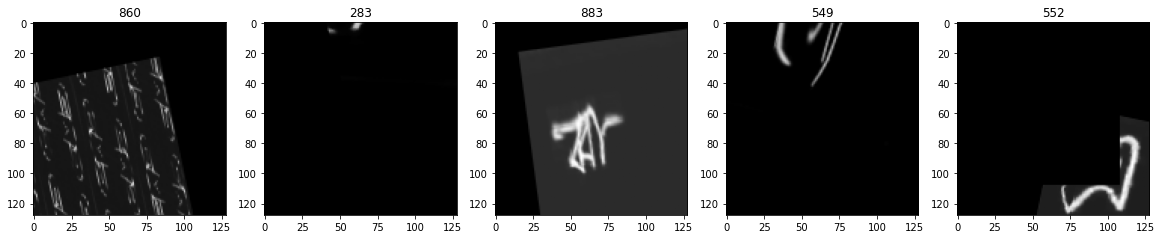

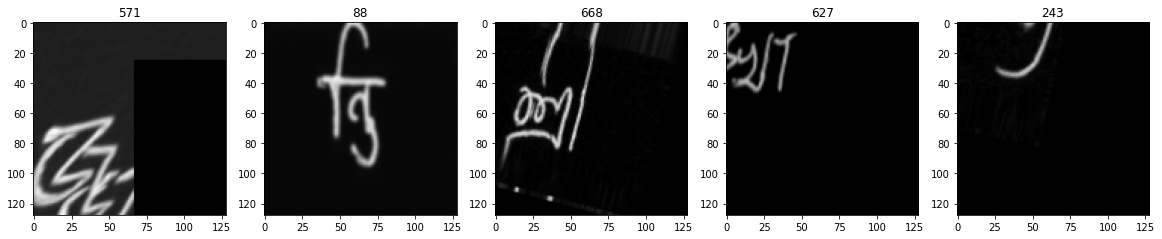

In [7]:
df_show = df_train.iloc[:1000]
dataset_show = BengaliDataset(df_show, data, list(range(df_show.shape[0])), 'train', 'train', transform=transforms_train)

from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, img_org, label = dataset_show[idx]
        axarr[p].imshow(img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(idx)

# Model

In [13]:
pretrained_dict = {f'efficientnet-b{i}': f for i, f in enumerate(sorted(glob.glob('bengali/efficientnet-pytorch/*pth')))}


sigmoid = torch.nn.Sigmoid()
class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * sigmoid(i)
        ctx.save_for_backward(i)
        return result

    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))

swish = Swish.apply

class Swish_module(nn.Module):
    def forward(self, x):
        return swish(x)

swish_layer = Swish_module()

def relu_fn(x):
    """ Swish activation function """
    return swish_layer(x)


class enet_3cg(nn.Module):

    def __init__(self, backbone, out_dim_1, out_dim_2):
        super(enet_3cg, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        self.enet.load_state_dict(torch.load(pretrained_dict[backbone]), strict=True)
        self.dropouts = nn.ModuleList([
            nn.Dropout(0.5) for _ in range(5)
        ])
        self.myfc_1 = nn.Linear(self.enet._fc.in_features, out_dim_2)
        self.activate = Swish_module()
        self.myfc_2 = nn.Linear(out_dim_2, out_dim_1)
        self.enet._fc = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        for i, dropout in enumerate(self.dropouts):
            if i == 0:
                out_2 = self.myfc_1(dropout(x))
            else:
                out_2 += self.myfc_1(dropout(x))
        out_2 /= len(self.dropouts)
        out_1 = self.myfc_2(self.activate(out_2))
        return out_1, out_2
    

# Loss Function

In [9]:
def criterion(logits_1, logits_2, target, loss_weight=loss_weight, is_val=False):
    loss_1 = nn.CrossEntropyLoss()(logits_2[:, :c1_dim], target[:, 1]) * loss_weight[1]
    loss_2 = nn.CrossEntropyLoss()(logits_2[:, c1_dim:c1_dim+c2_dim], target[:, 2]) * loss_weight[2]
    loss_3 = nn.CrossEntropyLoss()(logits_2[:, c1_dim+c2_dim:], target[:, 3]) * loss_weight[3]
    if is_val:
        loss = (loss_1 + loss_2 + loss_3) / sum(loss_weight[1:])
    else:
        loss_0 = nn.CrossEntropyLoss()(logits_1, target[:, 0]) * loss_weight[0]
        loss = (loss_0 + loss_1 + loss_2 + loss_3) / sum(loss_weight)
    return loss

CE = nn.CrossEntropyLoss()
def criterion_mix(logits_1, logits_2, target, loss_weight=loss_weight):
    target, shuffled_target, lam = target

    loss_0 = nn.CrossEntropyLoss()(logits_1, target[:, 0]) * loss_weight[0]
    loss_1 = nn.CrossEntropyLoss()(logits_2[:, :c1_dim], target[:, 1]) * loss_weight[1]
    loss_2 = nn.CrossEntropyLoss()(logits_2[:, c1_dim:c1_dim+c2_dim], target[:, 2]) * loss_weight[2]
    loss_3 = nn.CrossEntropyLoss()(logits_2[:, c1_dim+c2_dim:], target[:, 3]) * loss_weight[3]

    loss = (loss_0 + loss_1 + loss_2 + loss_3) / sum(loss_weight)
    
    loss_0_mix = nn.CrossEntropyLoss()(logits_1, shuffled_target[:, 0]) * loss_weight[0]
    loss_1_mix = nn.CrossEntropyLoss()(logits_2[:, :c1_dim], shuffled_target[:, 1]) * loss_weight[1]
    loss_2_mix = nn.CrossEntropyLoss()(logits_2[:, c1_dim:c1_dim+c2_dim], shuffled_target[:, 2]) * loss_weight[2]
    loss_3_mix = nn.CrossEntropyLoss()(logits_2[:, c1_dim+c2_dim:], shuffled_target[:, 3]) * loss_weight[3]

    loss_mix = (loss_0_mix + loss_1_mix + loss_2_mix + loss_3_mix) / sum(loss_weight)

    return lam * loss + (1 - lam) * loss_mix


def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

    
def cutmix(data, target, alpha, clip=[0.3, 0.7]):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]

    lam = np.clip(np.random.beta(alpha, alpha), clip[0], clip[1])
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, shuffled_target, lam)

    return data, targets

# Train & Val

In [10]:
def get_score(solution, submission):

    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[component].values
        y_pred_subset = submission[component].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2,1,1])
    return final_score


def train_epoch(loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, data_org, target) in bar:

        data, data_org, target = data.to(device), data_org.to(device), target.to(device)
        ### mixup & cutmix & cutout
        rand_p = np.random.rand()
        if rand_p <= 0.0:
            data, target = mixup(data_org, target, 1.)  # process from origin
            loss_func = criterion_mix
        elif 0.0 < rand_p <= 0.2:
            data, target = cutmix(data_org, target, 1.)  # process from origin
            loss_func = criterion_mix
        else:
            loss_func = criterion
        ###
        optimizer.zero_grad()
        logits_1, logits_2 = model(data)
        loss = loss_func(logits_1, logits_2, target)

        if not use_amp:
            loss.backward()
        else:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()

#         torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-20:]) / min(len(train_loss), 20)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss


def val_epoch(loader, get_output=False):

    model.eval()
    val_loss = []
    outputs = []
    LOGITS_1, LOGITS_2, LOGITS_M = [], [], []
    p1, p2, p3 = [], [], []
    masks = []
    acc, acc1, acc2, acc3 = 0.0,0.0,0.0,0.0

    with torch.no_grad():
        for (data, data_org, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits_1, logits_2 = model(data)

            loss = criterion(logits_1, logits_2, target, is_val=True)

            pred = logits_1.argmax(1).detach()
            pred1 = logits_2[:, :c1_dim].argmax(1).detach()
            pred2 = logits_2[:, c1_dim:c1_dim+c2_dim].argmax(1).detach()
            pred3 = logits_2[:, c1_dim+c2_dim:].argmax(1).detach()
            outputs.append(pred)
            p1.append(pred1)
            p2.append(pred2)
            p3.append(pred3)

            acc += (target[:, 0] == pred).sum().cpu().numpy()
            acc1 += (target[:, 1] == pred1).sum().cpu().numpy()
            acc2 += (target[:, 2] == pred2).sum().cpu().numpy()
            acc3 += (target[:, 3] == pred3).sum().cpu().numpy()
            
            if get_output:
                LOGITS_1.append(logits_1)
                LOGITS_2.append(logits_2)

            val_loss.append(loss.detach().cpu().numpy())

        val_loss = np.mean(val_loss)
        acc = acc / len(dataset_valid) * 100
        acc1 = acc1 / len(dataset_valid) * 100
        acc2 = acc2 / len(dataset_valid) * 100
        acc3 = acc3 / len(dataset_valid) * 100

    preds = torch.cat(outputs).cpu().numpy()
    solution = df_train.iloc[valid_idx]
    submission1 = df_label_map.iloc[preds]
    score1 = get_score(solution, submission1)
    
    submission2 = pd.DataFrame({
        'grapheme_root': torch.cat(p1).cpu().numpy(),
        'vowel_diacritic': torch.cat(p2).cpu().numpy(),
        'consonant_diacritic': torch.cat(p3).cpu().numpy(),
    })
    score2 = get_score(solution, submission2)

    if get_output:
        LOGITS_1 = torch.cat(LOGITS_1).cpu().numpy()
        LOGITS_2 = torch.cat(LOGITS_2).cpu().numpy()
        return LOGITS_1, LOGITS_2
    else:
        return val_loss, acc, acc1, acc2, acc3, score1, score2


# Main Loop

In [11]:
n_fold = 5
record = [{'train_loss': [], 'val_loss': [], 'score1': [], 'score2': []} for x in range(n_fold)]

In [15]:
i_fold = fold
train_idx, valid_idx = np.where((df_train['fold'] != i_fold))[0], np.where((df_train['fold'] == i_fold))[0]

dataset_train = BengaliDataset(df_train, data, train_idx, 'train', 'train', transform=transforms_train)
dataset_valid = BengaliDataset(df_train, data, valid_idx, 'train', 'val', transform=transforms_val)
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=None, num_workers=num_workers)

targets0 = df_train.loc[valid_idx]['grapheme_id'].values

model = enet_3cg(enet_type, out_dim_1=c0_dim, out_dim_2=c1_dim+c2_dim+c3_dim)
model = model.to(device)

max_score = 0
model_file = f'save/{kernel_type}_model_fold{i_fold}.pth'

print('Training All Layers...')
optimizer = optim.Adam(model.parameters(), lr=init_lr)
if use_amp:
    model, optimizer = amp.initialize(model, optimizer, opt_level="O1")
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
    scheduler_cosine.step(epoch-1)

    train_loss = train_epoch(train_loader, optimizer)
    val_loss, acc, acc1, acc2, acc3, score1, score2 = val_epoch(valid_loader)

    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f}, acc1: {(acc1):.5f}, acc2: {(acc2):.5f}, acc3: {(acc3):.5f}, score1: {(score1):.6f}, score2: {(score2):.6f}'
    print(content)
    with open(f'save/log_{kernel_type}.txt', 'a') as appender:
        appender.write(content + '\n')

    if score1 >= max_score:
        print('score2 ({:.6f} --> {:.6f}).  Saving model ...'.format(max_score, score1))
        torch.save(model.state_dict(), model_file)
        max_score = score1

    record[i_fold]['train_loss'].append(np.mean(train_loss))
    record[i_fold]['val_loss'].append(val_loss)
    record[i_fold]['score1'].append(np.mean(score1))
    record[i_fold]['score2'].append(score2)

torch.save(model.state_dict(), os.path.join(f'save/{kernel_type}_model_fold{i_fold}.pth'))

Training All Layers...
Mon May  4 17:05:23 2020 Epoch: 1


<ipython-input-10-46a55ca3a3e4>:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  bar = tqdm(loader)


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 10.92 GiB total capacity; 10.31 GiB already allocated; 5.56 MiB free; 10.38 GiB reserved in total by PyTorch)